In [13]:
%matplotlib inline
import numpy as np
import sys
sys.path.append('./utils/')
from sklearn.utils.extmath import *
from sklearn.utils.extmath import randomized_svd
import adaptoctree.morton as morton
import adaptoctree.tree as tree
import fmm.surface as surface
from scripts.precompute_operators import rsvd
from fmm.kernel import laplace_gram_matrix_serial
import matplotlib.pyplot as plt
from functions_from_matlab import krylov_schur_svd

# Matrix Creation

In [14]:
def compress_m2l_gram_matrix(
        dense_gram_matrix, level, x0, r0, depth, alpha_inner, check_surface,
        equivalent_surface, k, dtype
    ):
    """
    Compute compressed representation of unique Gram matrices for targets and
    sources at a given level of the octree, specified by their unique transfer
    vectors. Compression is computed using the randomised-SVD of Halko et. al.
    (2011).

    Parameters:
    -----------
    dense_gram_matrix: function
        Gram matrix function handle.
    level : int
        Octree level at which M2L operators are being calculated.
    x0 : np.array(shape=(1, 3), dtype=np.float64)
        Center of octree root node.
    r0 : np.float64
	    Half side length of octree root node.
    alpha_inner : float
        Relative size of inner surface.
    check_surface : np.array(shape=(ncheck_points, 3), dtype=float)
        Discretized check surface.
    equivalent_surface : np.array(shape=(nequivalent_points, 3), dtype=float)
        Discretized equivalent surface.
    k : int
        Target compression rank.

    Returns:
    --------
    (
        np.array(shape=(nu, k), float),
        np.array(shape=(ns), dtype=float),
        np.array(shape=(k, nvt), dtype=float),
        np.array(shape=(316), dtype=int)
    )
        Tuple of SVD components of aggregated M2L matrix at this level, as well
        as hashes of the transfer vectors to index the components by.
    """
    sources, targets, hashes = tree.find_unique_v_list_interactions(
        level=level, x0=x0, r0=r0, depth=depth
    )

    n_targets_per_node = len(check_surface)
    n_sources_per_node = len(equivalent_surface)
    n_sources = len(sources)

    # Create a collated equivalent to check surface for sources/targets
    # corresponding to unique transfer vectors at this level.
    se2tc = np.zeros((n_targets_per_node, n_sources*n_sources_per_node), dtype)

    for idx in range(len(targets)):

        target = targets[idx]
        source = sources[idx]

        target_center = morton.find_physical_center_from_key(
            key=target,
            x0=x0,
            r0=r0
        )

        source_center = morton.find_physical_center_from_key(
            key=source,
            x0=x0,
            r0=r0
        )

        lidx_sources = idx*n_sources_per_node
        ridx_sources = lidx_sources+n_sources_per_node

        target_check_surface = surface.scale_surface(
            surf=check_surface,
            radius=r0,
            level=level,
            center=target_center,
            alpha=alpha_inner
        )

        source_equivalent_surface = surface.scale_surface(
            surf=equivalent_surface,
            radius=r0,
            level=level,
            center=source_center,
            alpha=alpha_inner
        )

        se2tc[:, lidx_sources:ridx_sources] =  dense_gram_matrix(
                sources=source_equivalent_surface, targets=target_check_surface
            )

    return se2tc
    # Run RSVD compression.
    # u, s, vt = rsvd(se2tc, k)

    # return u, s, vt, hashes

In [15]:
order_equivalent = 15
order_check = 10
dtype = np.float32
equivalent_surface = surface.compute_surface(order_equivalent, dtype)
check_surface = surface.compute_surface(order_check, dtype)

In [16]:
equivalent_surface.shape

(1178, 3)

In [17]:
154208/316

488.0

In [18]:
check_surface.shape

(488, 3)

In [19]:
x0 = np.array([0., 0., 0.])
r0 = 0.5
alpha_inner = 1.05
alpha_outer = 1.95
k = 10
level = 2
depth = 3

In [20]:
se2tc = compress_m2l_gram_matrix(laplace_gram_matrix_serial, level, x0, r0, depth, alpha_inner, check_surface, equivalent_surface, k, dtype)

In [21]:
se2tc.shape

(488, 372248)

# 1) SVD

In [10]:
u, s, vt = np.linalg.svd(se2tc.T)

In [ ]:
plt.plot(s)

: 

In [ ]:
s

: 

# 2) Randomized SVD

In [36]:

u, s, v = randomized_svd(se2tc.T,n_components = 7)

In [37]:
s

array([1342.7596  ,  112.55653 ,  112.55621 ,  112.556206,   22.379858,
         22.379808,   22.379778], dtype=float32)

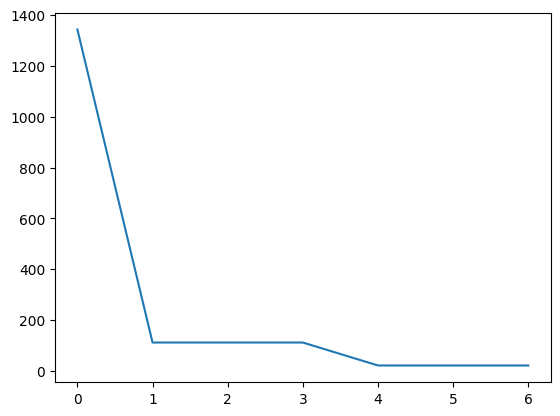

In [13]:
plt.plot(s)

# 3) Krylov Schur

In [25]:
se2tc

array([[0.12994945 , 0.13154171 , 0.1282377  , ..., 0.053197306,
        0.05355611 , 0.05391357 ],
       [0.12735508 , 0.12903792 , 0.1259146  , ..., 0.05375488 ,
        0.054111477, 0.054466296],
       [0.13224067 , 0.13412762 , 0.13082302 , ..., 0.054483354,
        0.054854747, 0.055224486],
       ...,
       [0.16492516 , 0.16946426 , 0.16601509 , ..., 0.062109243,
        0.06261867 , 0.06312688 ],
       [0.17203145 , 0.17672332 , 0.17282201 , ..., 0.061315484,
        0.061825875, 0.062335778],
       [0.17936309 , 0.18415819 , 0.17975593 , ..., 0.060521603,
        0.061031885, 0.06154236 ]], dtype=float32)

In [24]:
sigma, V, U, hist, mvs = krylov_schur_svd(mat, **{'nr': 7})

1
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.4
2.5
2.6
2.7
2.8
2.4
2.5
2.6
2.7
2.8
2.4
2.5
2.6
2.7
2.8
2.4
2.5
2.6
2.7
2.8
2.4
2.5
2.6
2.7
2.8
2.4
2.5
2.6
2.7
2.8
2.4
2.5
2.6
2.7
2.8
2.4
2.5
2.6
2.7
2.8
2.4
2.5
2.6
2.7
2.8
2.9
2
3
4.1
4.2
4.3
4.4
4.5
4.6
4.3
4.4
4.5
4.6
4.3
4.4
4.5
4.6
4.3
4.4
4.5
4.6
4.3
4.4
4.5
4.6
4.3
4.4
4.5
4.6
4.3
4.4
4.5
4.6
4.3
4.4
4.5
4.6
4.3
4.4
4.5
4.6
4.3
4.4
4.5
4.6
4.7
4
5
0: 9.99433296672052e-08
Found after 1 iteration(s) with residual = 9.99433296672052e-08


In [34]:
v1 = np.random.rand(se2tc.shape[0],1)

In [35]:
se2tc.T @ v1;

In [15]:
sigma

array([1342.7601806625364  ,  112.55619450920669 ,  112.55619432379504 ,
        112.55619385195403 ,   22.379819293069673,   22.37981916891529 ,
         22.37981915091967 ])

In [16]:
hist

array([3.361998342094237e-07])

In [17]:
mvs

array([20])

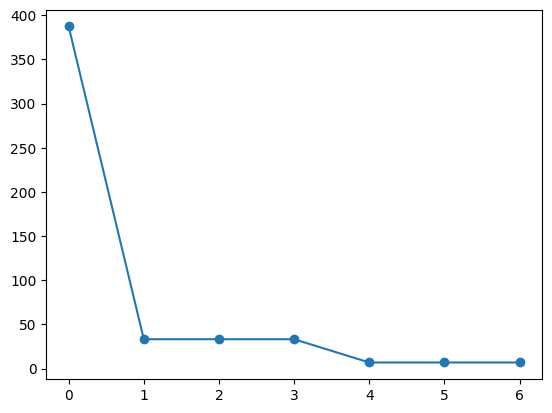

In [18]:
plt.plot(sigma,marker = 'o')

# Comparing Results of RSVD and Krylov Schur

In [44]:
max(s)

np.float32(1342.7596)

In [45]:
#Relative Error
np.abs(s - sigma)/max(max(np.abs(s)),max(np.abs(sigma)))

array([4.000028126007942e-07, 2.526916383246172e-07,
       1.419100109611254e-08, 8.860523121279694e-09,
       2.883902773639320e-08, 8.000693001747460e-09,
       3.071478814407756e-08])

In [38]:
rel_s = s/np.linalg.norm(s)
rel_sigma = sigma/np.linalg.norm(sigma)

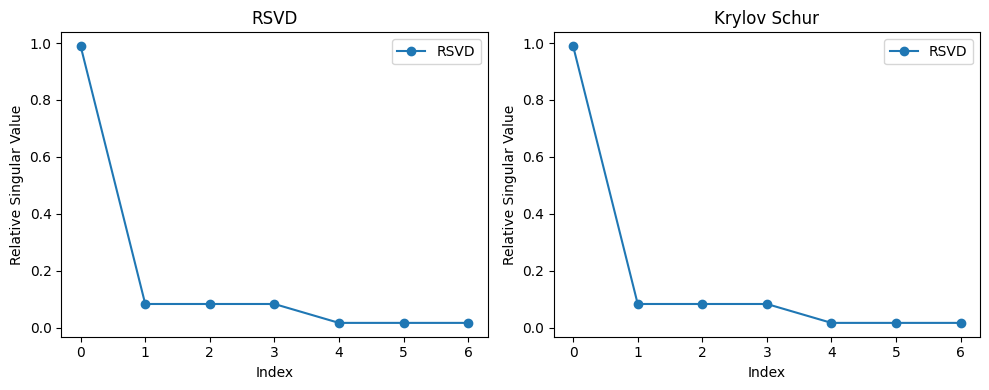

In [39]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot data on the first subplot
ax1.plot(rel_s, label='RSVD', marker = 'o')
ax1.set_title('RSVD')
ax1.set_xlabel('Index')
ax1.set_ylabel('Relative Singular Value')
ax1.legend()

# Plot data on the second subplot
ax2.plot(rel_sigma, label='RSVD', marker = 'o')
ax2.set_title('Krylov Schur')
ax2.set_xlabel('Index')
ax2.set_ylabel('Relative Singular Value')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Matrix MATLAB File Upload

In [20]:
from scipy.io import savemat

In [21]:
a = se2tc.T
mdic = {"a": a, "label": "experiment"}

In [22]:
folder_path = '/Users/chamundeshwarivadamalai/Desktop/MLF/MATLAB_Timo/ks_svd/'
file_name = 'matlab_matrix.mat'
full_path = folder_path + file_name

In [23]:
savemat(full_path, mdic)